In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  MaxPooling2D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
import os
import moviepy.editor as mp
%matplotlib inline

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [19]:
import os

# Set dataset directories
train_dir = os.path.join("dataset", "train")
test_dir = os.path.join("dataset", "test")

print("Training data path:", os.path.abspath(train_dir))

print("Testing data path:", os.path.abspath(test_dir))


Training data path: C:\Users\Administrator\human_action_recognition.ipynb\dataset\train
Testing data path: C:\Users\Administrator\human_action_recognition.ipynb\dataset\test


In [20]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

def load_images_from_folder(folder_path, img_size=(64, 64)):
    images = []
    labels = []
    classes = sorted(os.listdir(folder_path))
    print("📂 Classes found:", classes)

    
    for class_idx, class_name in enumerate(classes):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue
        
        for file_name in os.listdir(class_folder):
            if not file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            img_path = os.path.join(class_folder, file_name)
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(class_idx)
            except Exception as e:
                print(f"⚠️ Error reading {img_path}: {e}")
                
    images = np.array(images) / 255.0  
    labels = to_categorical(labels, num_classes=len(classes))
    print(f"✅ Loaded {len(images)} images from {folder_path}")
    return images, labels #this is my cell 3 (om yadao)

In [21]:
train_data, train_labels = load_images_from_folder(train_dir)
test_data, test_labels = load_images_from_folder(test_dir)


📂 Classes found: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
✅ Loaded 10710 images from dataset\train
📂 Classes found: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
✅ Loaded 1890 images from dataset\test


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(train_data)  
IMG_SIZE = 128
NUM_CLASSES = 15


In [26]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

input_shape = (64, 64, 3)  # image shape
num_classes = train_labels.shape[1]  # 15

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,627,087 (6.21 MB)

 Trainable params: 1,627,087 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    datagen.flow(train_data, train_labels, batch_size=32),
    validation_data=(test_data, test_labels),
    epochs=30,
    callbacks=[early_stop]
)


  self._warn_if_super_not_called()



Epoch 1/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 58s 151ms/step - accuracy: 0.1046 - loss: 2.6671 - val_accuracy: 0.1471 - val_loss: 2.5466
Epoch 2/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 43s 129ms/step - accuracy: 0.1321 - loss: 2.5763 - val_accuracy: 0.2032 - val_loss: 2.4314
Epoch 3/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 38s 113ms/step - accuracy: 0.1645 - loss: 2.4989 - val_accuracy: 0.1778 - val_loss: 2.6029
Epoch 4/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 38s 112ms/step - accuracy: 0.1902 - loss: 2.4548 - val_accuracy: 0.2397 - val_loss: 2.3204
Epoch 5/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 35s 103ms/step - accuracy: 0.2025 - loss: 2.4228 - val_accuracy: 0.2429 - val_loss: 2.3548
Epoch 6/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - accuracy: 0.2134 - loss: 2.3777 - val_accuracy: 0.2852 - val_loss: 2.1886
Epoch 7/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 37s 109ms/step - accuracy: 0.2163 - loss: 2.3614 - val_accuracy: 0.2841 - val_loss: 2.1911
Epoch 8/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 32s 96ms/step - accuracy: 0.2317 - loss: 2.

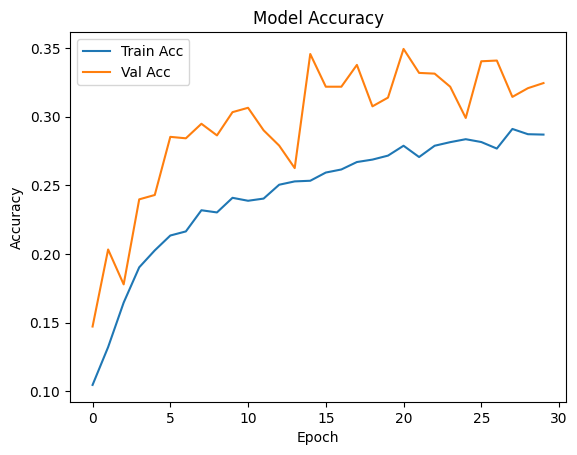

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)

print(classification_report(y_true_classes, y_pred_classes))
print(confusion_matrix(y_true_classes, y_pred_classes))


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step  
              precision    recall  f1-score   support

           0       0.25      0.10      0.15       126
           1       0.28      0.27      0.27       126
           2       0.48      0.77      0.59       126
           3       0.35      0.64      0.46       126
           4       0.22      0.08      0.12       126
           5       0.48      0.56      0.52       126
           6       0.49      0.50      0.50       126
           7       0.34      0.19      0.24       126
           8       0.40      0.29      0.34       126
           9       0.16      0.18      0.17       126
          10       0.41      0.30      0.35       126
          11       0.25      0.30      0.27       126
          12       0.53      0.34      0.42       126
          13       0.16      0.04      0.06       126
          14       0.22      0.52      0.31       126

    accuracy                           0.34      1890
   macro avg       0.33      0.34     

In [13]:
model.save('models/action_image_model.h5')


In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)

print(classification_report(y_true_classes, y_pred_classes))
print(confusion_matrix(y_true_classes, y_pred_classes))


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
              precision    recall  f1-score   support

           0       0.25      0.10      0.15       126
           1       0.28      0.27      0.27       126
           2       0.48      0.77      0.59       126
           3       0.35      0.64      0.46       126
           4       0.22      0.08      0.12       126
           5       0.48      0.56      0.52       126
           6       0.49      0.50      0.50       126
           7       0.34      0.19      0.24       126
           8       0.40      0.29      0.34       126
           9       0.16      0.18      0.17       126
          10       0.41      0.30      0.35       126
          11       0.25      0.30      0.27       126
          12       0.53      0.34      0.42       126
          13       0.16      0.04      0.06       126
          14       0.22      0.52      0.31       126

    accuracy                           0.34      1890
   macro avg       0.33      0.34      0

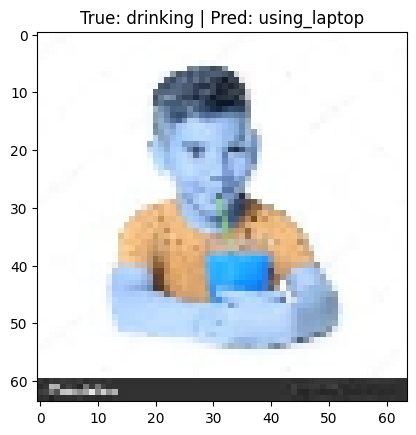

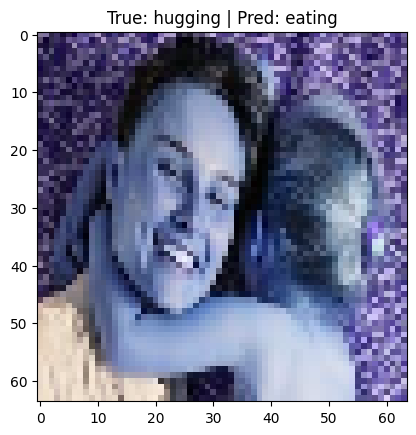

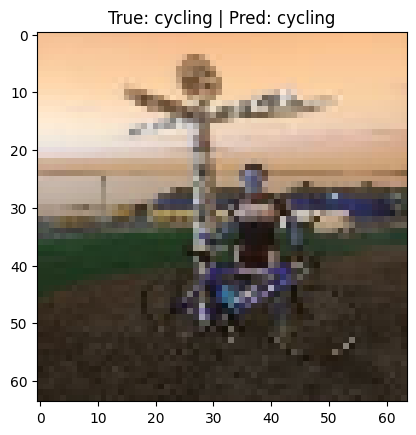

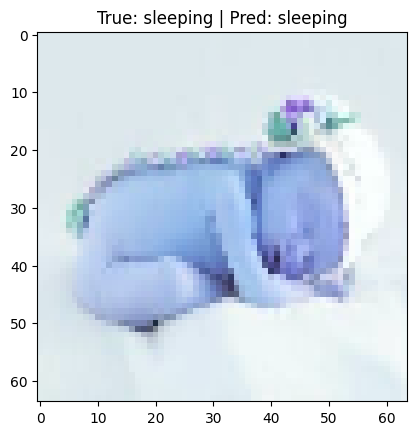

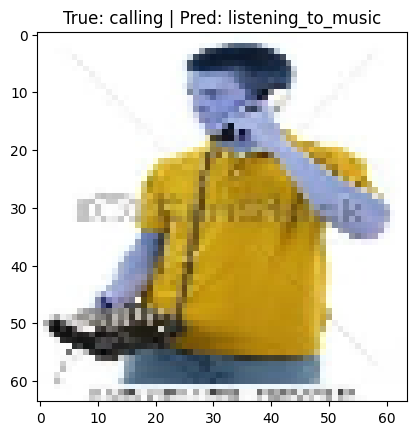

In [34]:
import matplotlib.pyplot as plt

class_names = ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 
               'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 
               'sitting', 'sleeping', 'texting', 'using_laptop']

for i in range(5):  # Show 5 random examples
    idx = np.random.randint(0, len(test_data))
    plt.imshow(test_data[idx])
    plt.title(f"True: {class_names[y_true_classes[idx]]} | Pred: {class_names[y_pred_classes[idx]]}")
    plt.show()


In [15]:
import streamlit as st
from tensorflow.keras.models import load_model
import numpy as np
import cv2

model = load_model('models/action_image_model.h5')  # or .h5 if you used that

st.title("Human Action Recognition Demo")
uploaded_file = st.file_uploader("Upload an action image...", type=["jpg", "png", "jpeg"])

class_names = ['calling', 'clapping', ...]  # as before

if uploaded_file is not None:
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    img = cv2.imdecode(file_bytes, 1)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    pred = model.predict(np.expand_dims(img, axis=0))
    st.image(img, channels="BGR")
    st.write("Prediction:", class_names[np.argmax(pred)])


2025-10-28 10:15:29.610 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-28 10:15:30.722 
  command:

    streamlit run D:\anacondadownload\envs\action_recognition\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-10-28 10:15:30.723 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-28 10:15:30.724 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-28 10:15:30.724 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-28 10:15:30.725 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-28 10:15:30.727 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-28 10:15:30.739 Thre

In [16]:
from tensorflow.keras.models import load_model

model = load_model('models/action_image_model.h5')
print("✅ Model input shape:", model.input_shape)


✅ Model input shape: (None, 128, 128, 3)
